In [1]:
# librairies
import pandas as pd
import numpy as np 
import string 
import sys
import os 

# for visualization 
# Plot confusion matrix
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
import seaborn as sn

In [2]:
import re
import gensim
import nltk
import keras
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, SpatialDropout1D, SimpleRNN
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd drive/MyDrive/Colab

/content/drive/MyDrive/Colab


## Processing the data 


In [5]:
# import the dataset

# Path Kodjo
# path = '/home/anselme/Desktop/Etude/MVA_S1/DL/MVA_DL/Data Mining'

dataset = pd.read_excel('dataset.xlsx', skiprows=0)

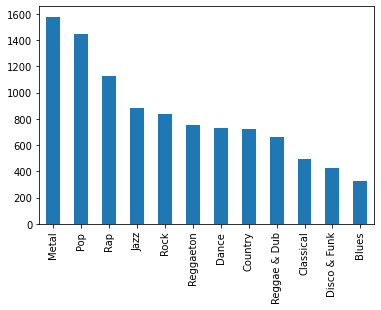

In [6]:
dataset['Class'].value_counts().plot(kind='bar')
plt.show()

In [7]:
from sklearn.utils import shuffle
dataset = shuffle(dataset)

dataset

,Name,Artist,Album,Release Date,Lyrics,Class
3741,Half As Lovely Twice As True,Frank Sinatra,NaN,NaN,If your eyes were half as bright\nThey still w...,Jazz
9247,Rock Steady,The Whispers,The Complete Solar Hit Singles Collection,2014-09-08,Rock\nRock steady\n\n[Verse 1:]\nI looked at y...,Disco & Funk
9054,Prayer To Jah,The Gladiators,Back To Roots,2000,Father today I cry to thee\nLet not my enemies...,Reggae & Dub
5372,Vicky,Joyce Santana,Vicky (Remix),2020-04-03,"[Letra de ""Vicky""]\n\n[Intro]\nYeh, lo' verdad...",Reggaeton
4056,My Way Of Life,Frank Sinatra,Cycles,NaN,"Gotta have you near all the time, with your dr...",Jazz
...,...,...,...,...,...,...
3787,I Couldn’t Sleep a Wink Last Night,Frank Sinatra,Close to You,NaN,I couldn't sleep a wink last night\nBecause we...,Jazz
6546,Born To Love,MEDUZA,Born To Love (feat. SHELLS),2020-02-14,[Verse]\nI was born to love\nTo feel that touc...,Dance
4445,The Fugitive,Gregory Isaacs,More Gregory,1981,I feel like singing sad songs all night\nI fee...,Reggae & Dub
852,Goodbye To The Circus,Aqua,Aquarius (Special Edition),2000-01-01,[Verse 1]\nIt's time now to turn off the light...,Pop


In [8]:
# Process lyrics
dataset["Lyrics"] = dataset["Lyrics"].str.replace('chorus','')

# Lyrics
Lyrics = [dataset['Lyrics'][i] for i in range(dataset.shape[0])]

# labels 
yData  = [dataset['Class'][i]  for i in range(dataset.shape[0])]


# remove text between [] (corresponds to Chrous / verse headings)
Lyrics = [re.sub("\[.*?\]", "",Lyrics[i]) for i in range( dataset.shape[0])]

# Clean up data (replace \n, [, (, ], ) par "")
Lyrics = [Lyrics[i].replace('\n', ' ') for i in  range( dataset.shape[0])]
Lyrics = [Lyrics[i].replace('[' ,  '') for i in  range( dataset.shape[0])]
Lyrics = [Lyrics[i].replace(']' ,  '') for i in  range( dataset.shape[0])]
Lyrics = [Lyrics[i].replace('(' ,  '') for i in  range( dataset.shape[0])]
Lyrics = [Lyrics[i].replace(')' ,  '') for i in  range( dataset.shape[0])]

#for i in range(100):
#  print(Lyrics[i])

xData = []
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

for Lyric in Lyrics:
    # Tokenize each lyric, and set all characters to lower-case
    tokens = word_tokenize(Lyric)
    tokens = [word.lower() for word in tokens]
    
    # Remove punctuation
    tokens_nopunc = [word.translate(translator) for word in tokens]
    
    # Remove non-alphabetic tokens
    words = [word for word in tokens_nopunc if word.isalpha()]
    
    # Remove stop words from the lyric
    words = [word for word in words if not word in stop_words]
    
    # Append to training data
    xData.append(words)

for i in range(10):
  print(xData[i])

['hot', 'hot', 'l', 'let', 'tell', 'wan', 'na', 'let', 'show', 'feelin', 'wan', 'na', 'freak', 'wan', 'na', 'ride', 'wan', 'na', 'taste', 'wan', 'na', 'put', 'lips', 'ca', 'nt', 'get', 'enough', 'always', 'sweet', 'ca', 'nt', 'forget', 'good', 'girl', 'make', 'sweat', 'girl', 'talkin', 'bout', 'peaches', 'cream', 'oooh', 'need', 'cause', 'know', 'fiend', 'right', 'gettin', 'freaky', 'bentley', 'limousine', 'even', 'better', 'ice', 'cream', 'know', 'mean', 'peaches', 'cream', 'need', 'cause', 'know', 'fiend', 'gettin', 'freaky', 'bentley', 'limousine', 'even', 'better', 'ice', 'cream', 'girl', 'taste', 'good', 'know', 'mean', 'peaches', 'cream', 'never', 'thought', 'would', 'addicted', 'top', 'underneath', 'side', 'better', 'yet', 'baby', 'right', 'next', 'love', 'way', 'flowin', 'feel', 'around', 'front', 'back', 'ooh', 'love', 'smell', 'girl', 'know', 'talking', 'hook', 'q', 'peaches', 'cream', 'need', 'cause', 'know', 'fiend', 'ooh', 'gettin', 'freaky', 'bentley', 'limousine', 'ooohh

In [9]:
# Loads pre-trained GloVe word embeddings

# Load in GloVe file and initialize embedding index
filename = 'glove.6B.300d.txt'
file = open(os.path.join('', filename), encoding = "utf-8")
embeddings_index = {}

for line in file:
   
    # Add each embedding to the embedding index
    embedding = line.split()
    embeddings_index[embedding[0]] = np.asarray(embedding[1:])

file.close()

In [10]:
# Map each word token in the training data to an integer

# For each training example, maps each word token to an integer
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(xData)
xData_seq = tokenizer.texts_to_sequences(xData)

In [11]:
# Pad sequences shorter than max length 
max_num_tokens = max([len(tokenized_lyric) for tokenized_lyric in xData])
xData_seq_padded = pad_sequences(xData_seq, maxlen=max_num_tokens)

In [12]:
# Map GloVe word embeddings to each word in the tokenizer word index to create a matrix of word embeddings

# Initialize embedding matrix
EMBEDDING_DIM = 300
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# Populate embedding matrix
for word, i in word_index.items():
    
    if i > num_words:
        continue
        
    # Assign corresponding GloVe embedding to the given word
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        # Words not found in the embedding are assigned a zero vector by default
        embedding_matrix[i] = embedding_vector

In [13]:
# Shuffles the data, and splits it into train and test sets
np.random.seed(0)

VALIDATION_SPLIT = 0.1
word_indices = np.arange(xData_seq_padded.shape[0])
np.random.shuffle(word_indices)
xData_seq_padded = xData_seq_padded[word_indices]
mood = np.array(yData)
mood = mood[word_indices]

# Binarizes the mood labels
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
moods = encoder.fit_transform(mood.tolist())

# Splits the dataset into train and test sets
num_validation_samples = int(VALIDATION_SPLIT * xData_seq_padded.shape[0])

X_train_pad = xData_seq_padded[:-(2 * num_validation_samples)]
y_train = moods[:-(2 * num_validation_samples)]

X_val_pad = xData_seq_padded[-(2 * num_validation_samples):-num_validation_samples]
y_val = moods[-(2 * num_validation_samples):-num_validation_samples]

X_test_pad = xData_seq_padded[-num_validation_samples:]
y_test = moods[-num_validation_samples:]

print("Train set length: {}".format(len(X_train_pad)))
print("Validation set length: {}".format(len(X_val_pad)))
print("Test set length: {}".format(len(X_test_pad)))

Train set length: 8000
Validation set length: 1000
Test set length: 1000


In [14]:
# Defines the Multiclass model, compiles and trains it
from keras.layers import add

model = Sequential()
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM, 
                            embeddings_initializer=Constant(embedding_matrix), 
                            input_length=max_num_tokens,
                            trainable=False)

model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(48, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='softmax'))

checkpoint_filepath = 'checkpoint1'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose=1)

op = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = op, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

# Saves a History object for plotting
history = model.fit(X_train_pad, y_train, batch_size=16, epochs=30, 
                    validation_data=(X_val_pad, y_val), verbose=2, callbacks=[model_checkpoint_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1702, 300)         20604600  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1702, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1700, 256)         230656    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 48)                12336     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3

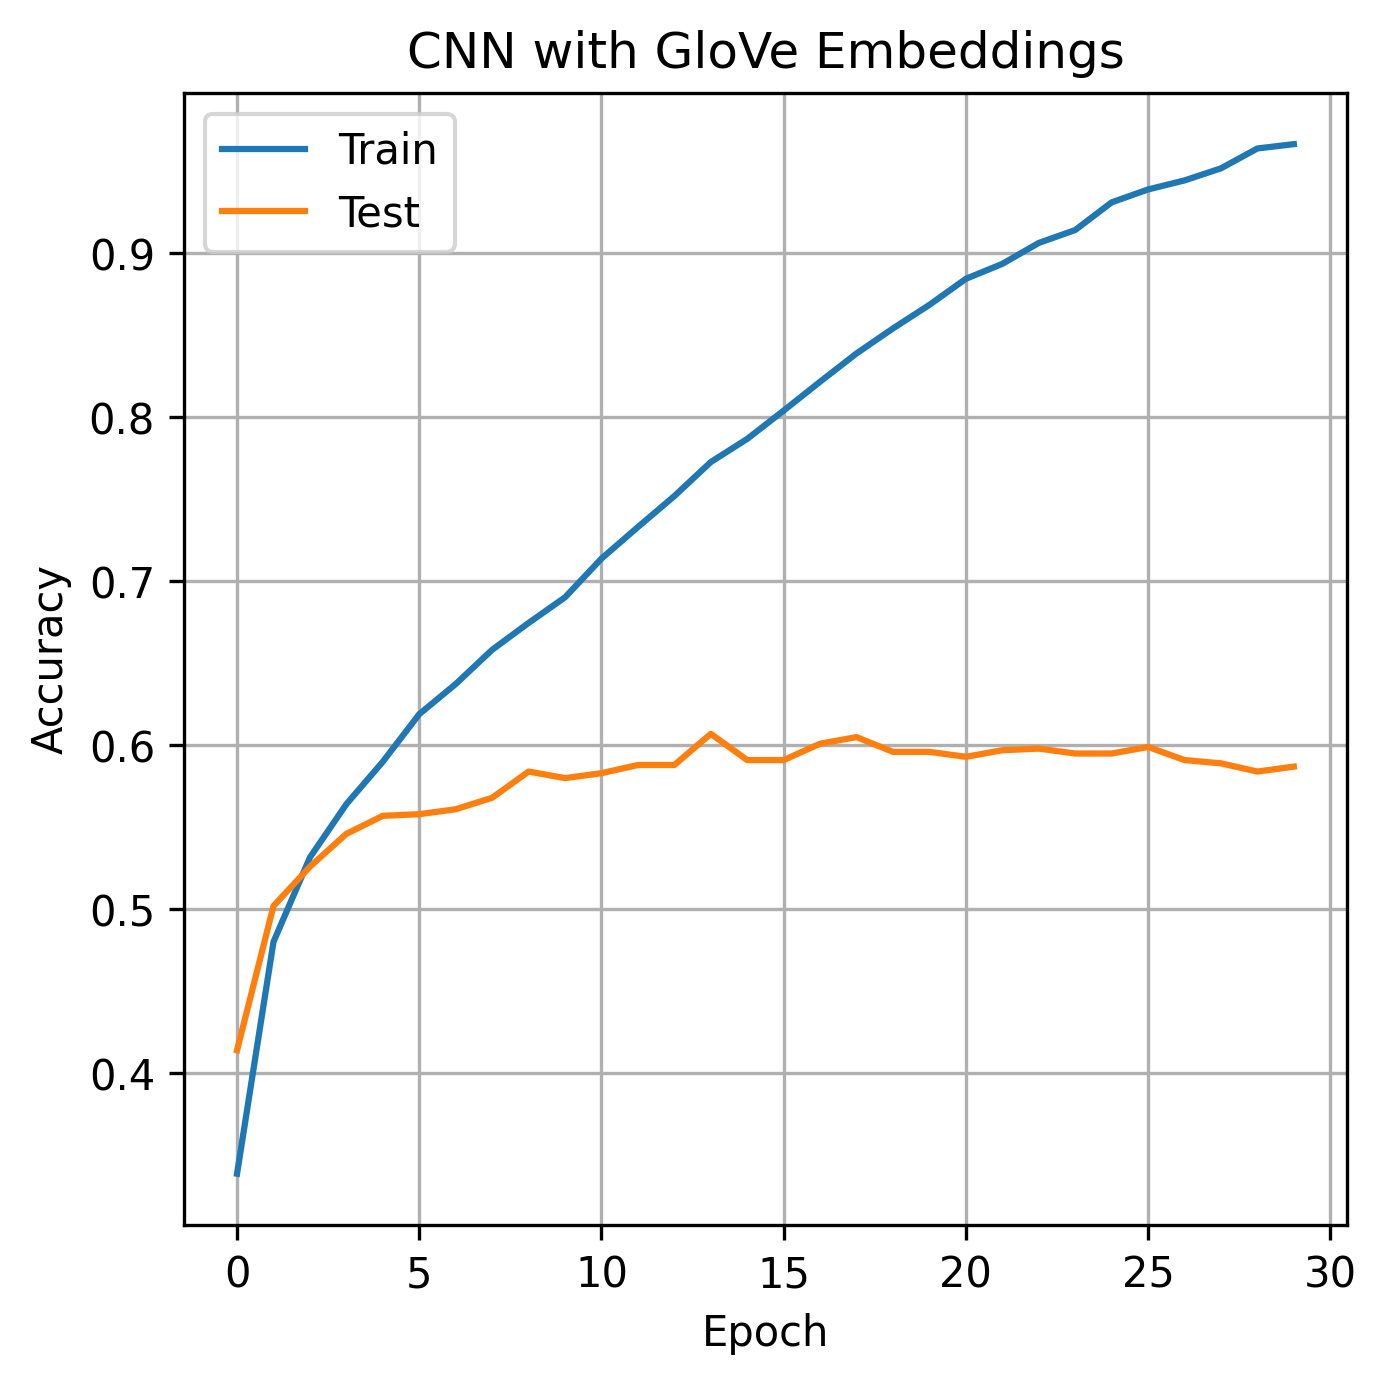

In [15]:
# Plot accuracy as a function of training epoch

figure(num=None, figsize=(5, 5), dpi=300)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True)
plt.title('CNN with GloVe Embeddings')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
model.load_weights(checkpoint_filepath)

results = model.evaluate(X_test_pad, y_test, batch_size=16)
print("test loss, test acc:", results)

print(model.summary())

63/63 [==============================] - 1s 16ms/step - loss: 1.1283 - accuracy: 0.6470
test loss, test acc: [1.1282689571380615, 0.6470000147819519]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1702, 300)         20604600  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1702, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1700, 256)         230656    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 48)                12336     
_________________________________________________________________
dense_1 (Dense)              (None, 24

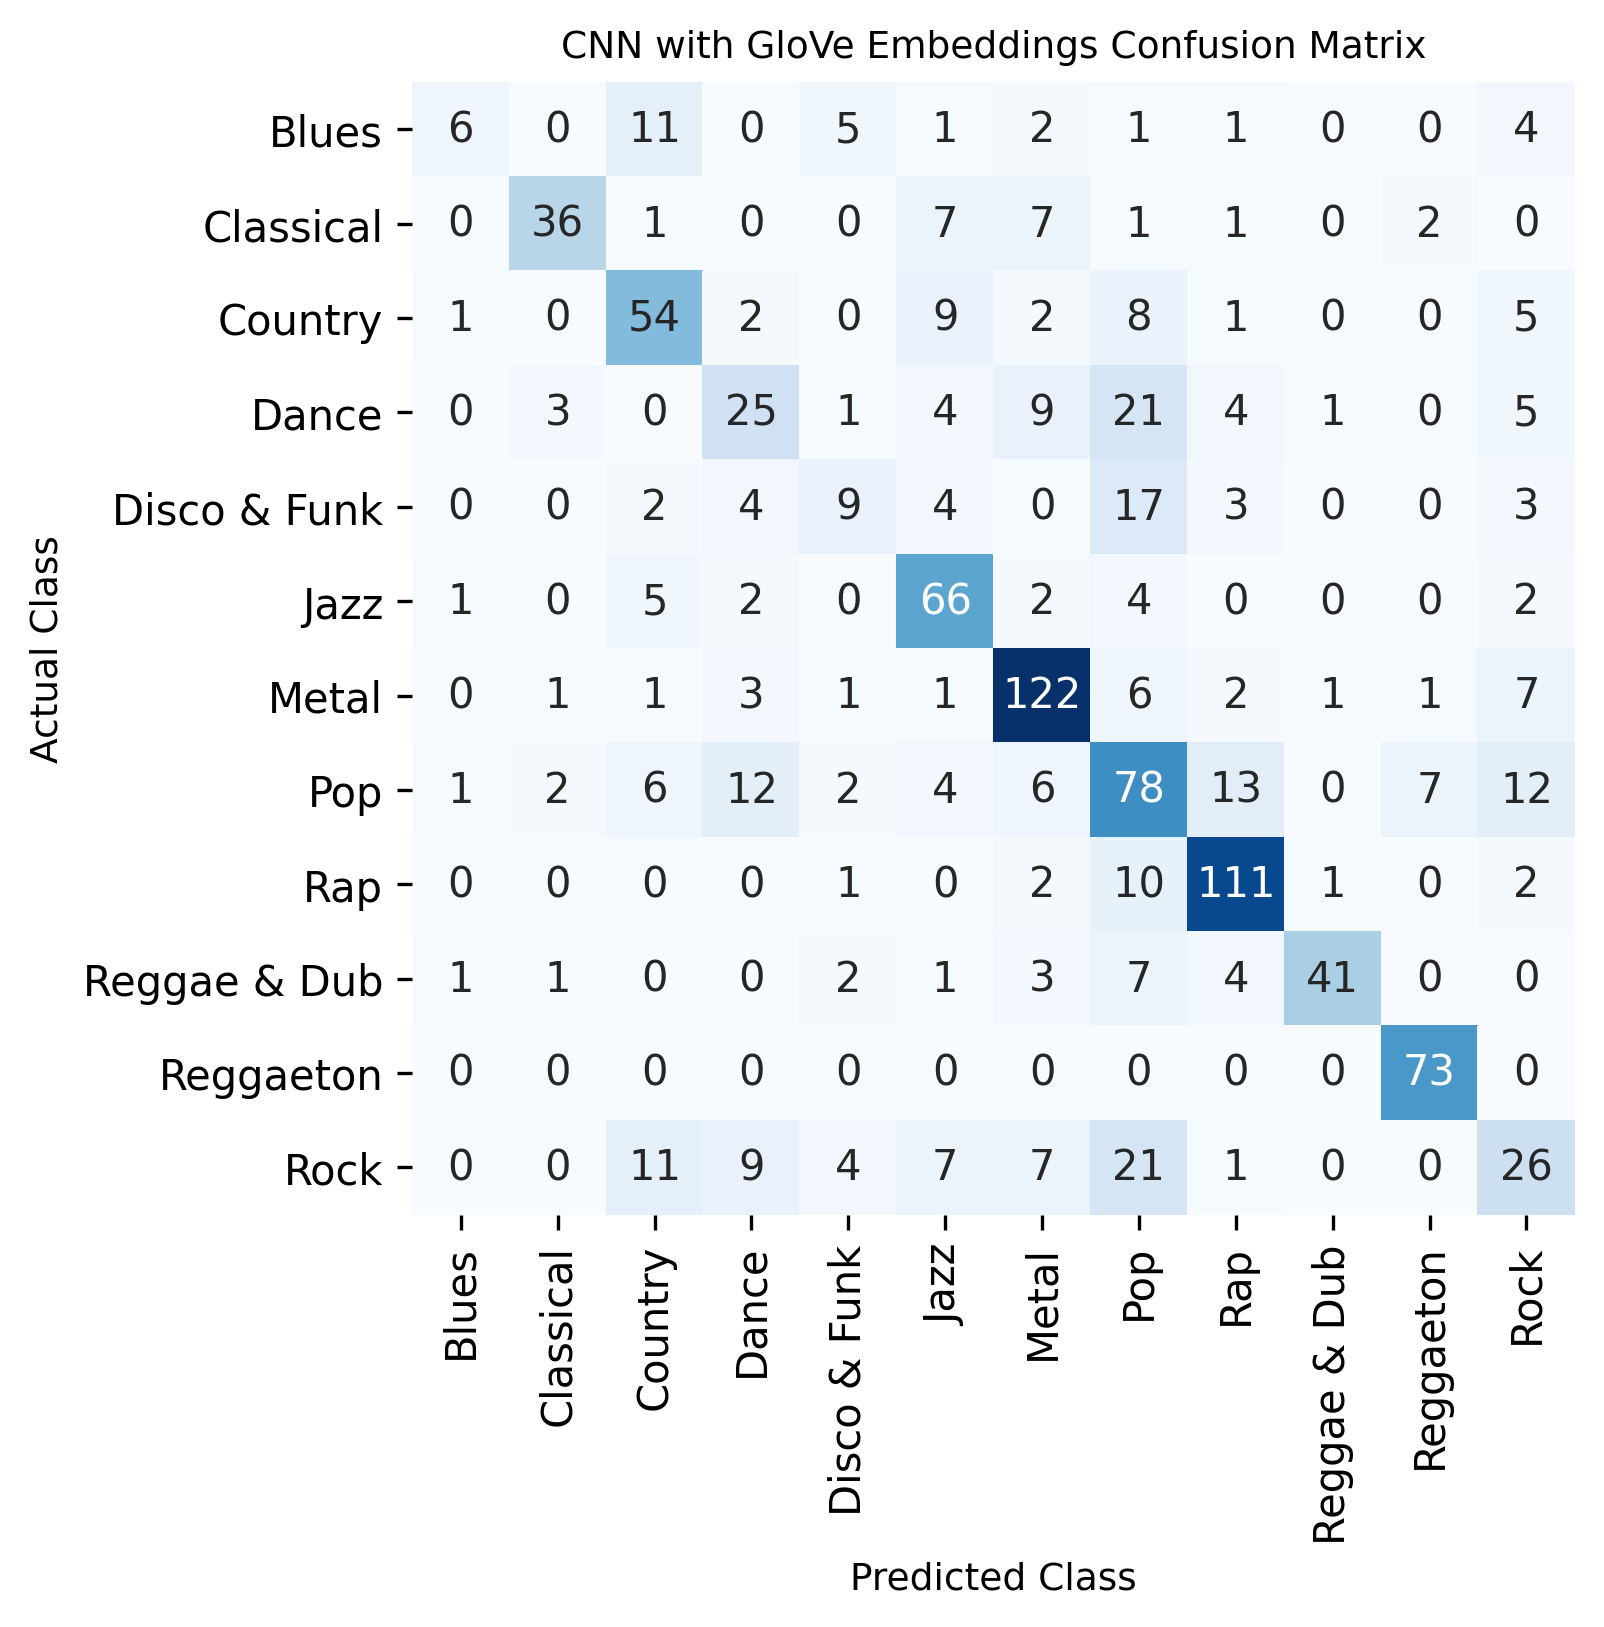

In [23]:
# Plot confusion matrix
alphabetical = []

for el in mood:
    if (el not in alphabetical):
        alphabetical.append(el)

alphabetical = sorted(alphabetical)

# Gets predicted labels from model
y_pred = model.predict(X_test_pad)

# Formats labels into appropriate class designations
y_pred_classes = np.zeros(len(y_pred)).astype(int)
y_test_classes = np.zeros(len(y_test)).astype(int)

for index, label in enumerate(y_pred):
    y_pred_classes[index] = np.argmax(y_pred[index])
    
for index, label in enumerate(y_test):
    y_test_classes[index] = np.argmax(y_test[index])

# Generates confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Formats and displays the confusion matrix
figure(num=None, figsize=(5, 5), dpi=300)
df_cm = pd.DataFrame(cm, index = alphabetical, columns = alphabetical)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues, fmt='g', cbar=False)
plt.title('CNN with GloVe Embeddings Confusion Matrix', fontsize=9)
plt.xlabel("Predicted Class", fontsize=9)
plt.ylabel("Actual Class", fontsize=9)
plt.show()

In [24]:
# Cell for getting information about each class

from sklearn.metrics import classification_report

new_test_classes = np.full(shape=y_test_classes.shape[0], fill_value="yoooooooooooooooo")
new_pred_classes = np.full(shape=y_pred_classes.shape[0], fill_value="yoooooooooooooooo")

for x in range(len(y_test_classes)):
    id1 = y_test_classes[x]
    id2 = y_pred_classes[x]

    word1 = alphabetical[id1]
    word2 = alphabetical[id2]

    new_test_classes[x] = word1
    new_pred_classes[x] = word2

print(classification_report(new_test_classes, new_pred_classes))

              precision    recall  f1-score   support

       Blues       0.60      0.19      0.29        31
   Classical       0.84      0.65      0.73        55
     Country       0.59      0.66      0.62        82
       Dance       0.44      0.34      0.38        73
Disco & Funk       0.36      0.21      0.27        42
        Jazz       0.63      0.80      0.71        82
       Metal       0.75      0.84      0.79       146
         Pop       0.45      0.55      0.49       143
         Rap       0.79      0.87      0.83       127
Reggae & Dub       0.93      0.68      0.79        60
   Reggaeton       0.88      1.00      0.94        73
        Rock       0.39      0.30      0.34        86

    accuracy                           0.65      1000
   macro avg       0.64      0.59      0.60      1000
weighted avg       0.64      0.65      0.63      1000



In [19]:
# Defines the Multiclass model, compiles and trains it

lstm = Sequential()
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM, 
                            embeddings_initializer=Constant(embedding_matrix), 
                            input_length=max_num_tokens,
                            trainable=False)

lstm.add(embedding_layer)
lstm.add(SpatialDropout1D(0.2))
lstm.add(Bidirectional(CuDNNLSTM(100)))
lstm.add(Dense(48, activation='relu'))
lstm.add(Dense(24, activation='relu'))
lstm.add(Dense(12, activation='softmax'))

checkpoint_filepath = 'LSTM1'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose=1)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

op = keras.optimizers.Adam(learning_rate = lr_schedule)
lstm.compile(optimizer = op, loss='categorical_crossentropy', metrics=['accuracy'])

print(lstm.summary())

# Saves a History object for plotting
history = lstm.fit(X_train_pad, y_train, batch_size=128, epochs=30, 
                    validation_data=(X_val_pad, y_val), verbose=2, callbacks=[model_checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1702, 300)         20604600  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1702, 300)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               321600    
_________________________________________________________________
dense_3 (Dense)              (None, 48)                9648      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                300       
Total params: 20,937,324
Trainable params: 332,724
Non-trainable params: 20,604,600
____________________________________

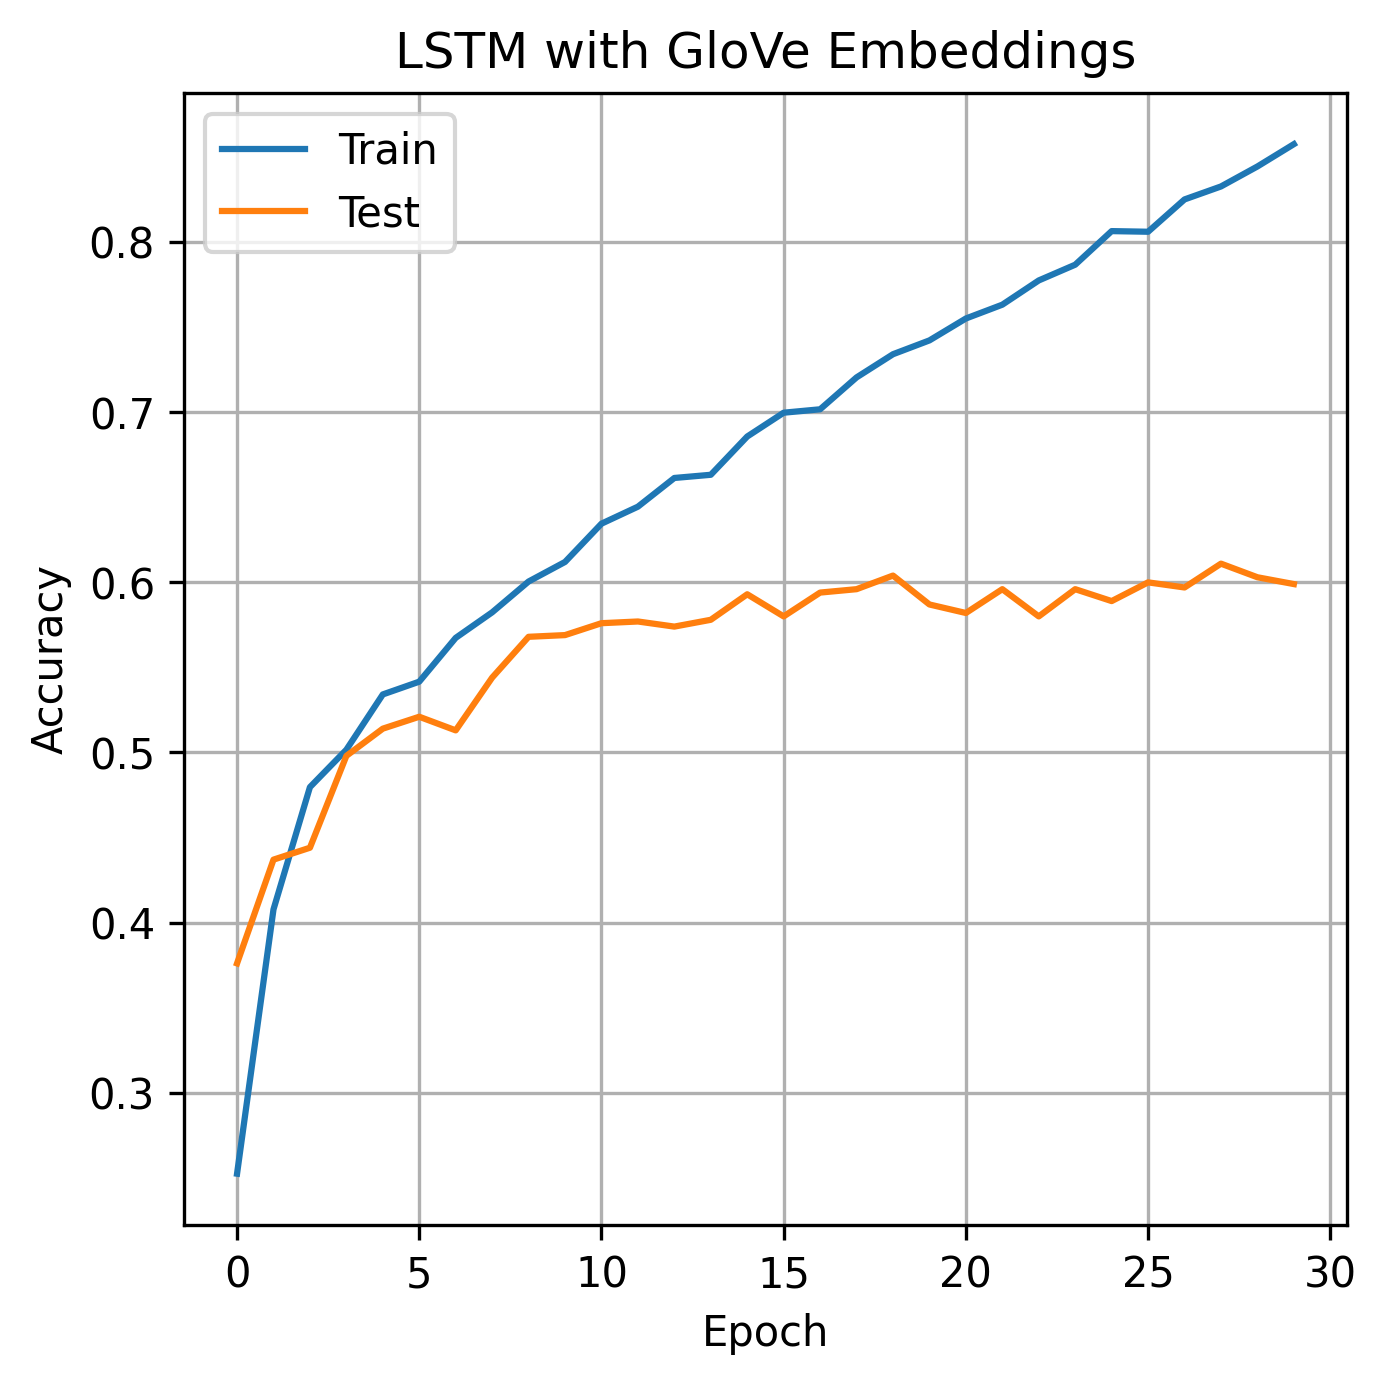

In [21]:
# Plot accuracy as a function of training epoch

figure(num=None, figsize=(5, 5), dpi=300)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True)
plt.title('LSTM with GloVe Embeddings')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
lstm.load_weights(checkpoint_filepath)

results = lstm.evaluate(X_test_pad, y_test, batch_size=128)
print("test loss, test acc:", results)

print(lstm.summary())

8/8 [==============================] - 1s 169ms/step - loss: 1.4238 - accuracy: 0.6200
test loss, test acc: [1.4237984418869019, 0.6200000047683716]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1702, 300)         20604600  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1702, 300)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               321600    
_________________________________________________________________
dense_3 (Dense)              (None, 48)                9648      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_5 (Dense)              (None, 1

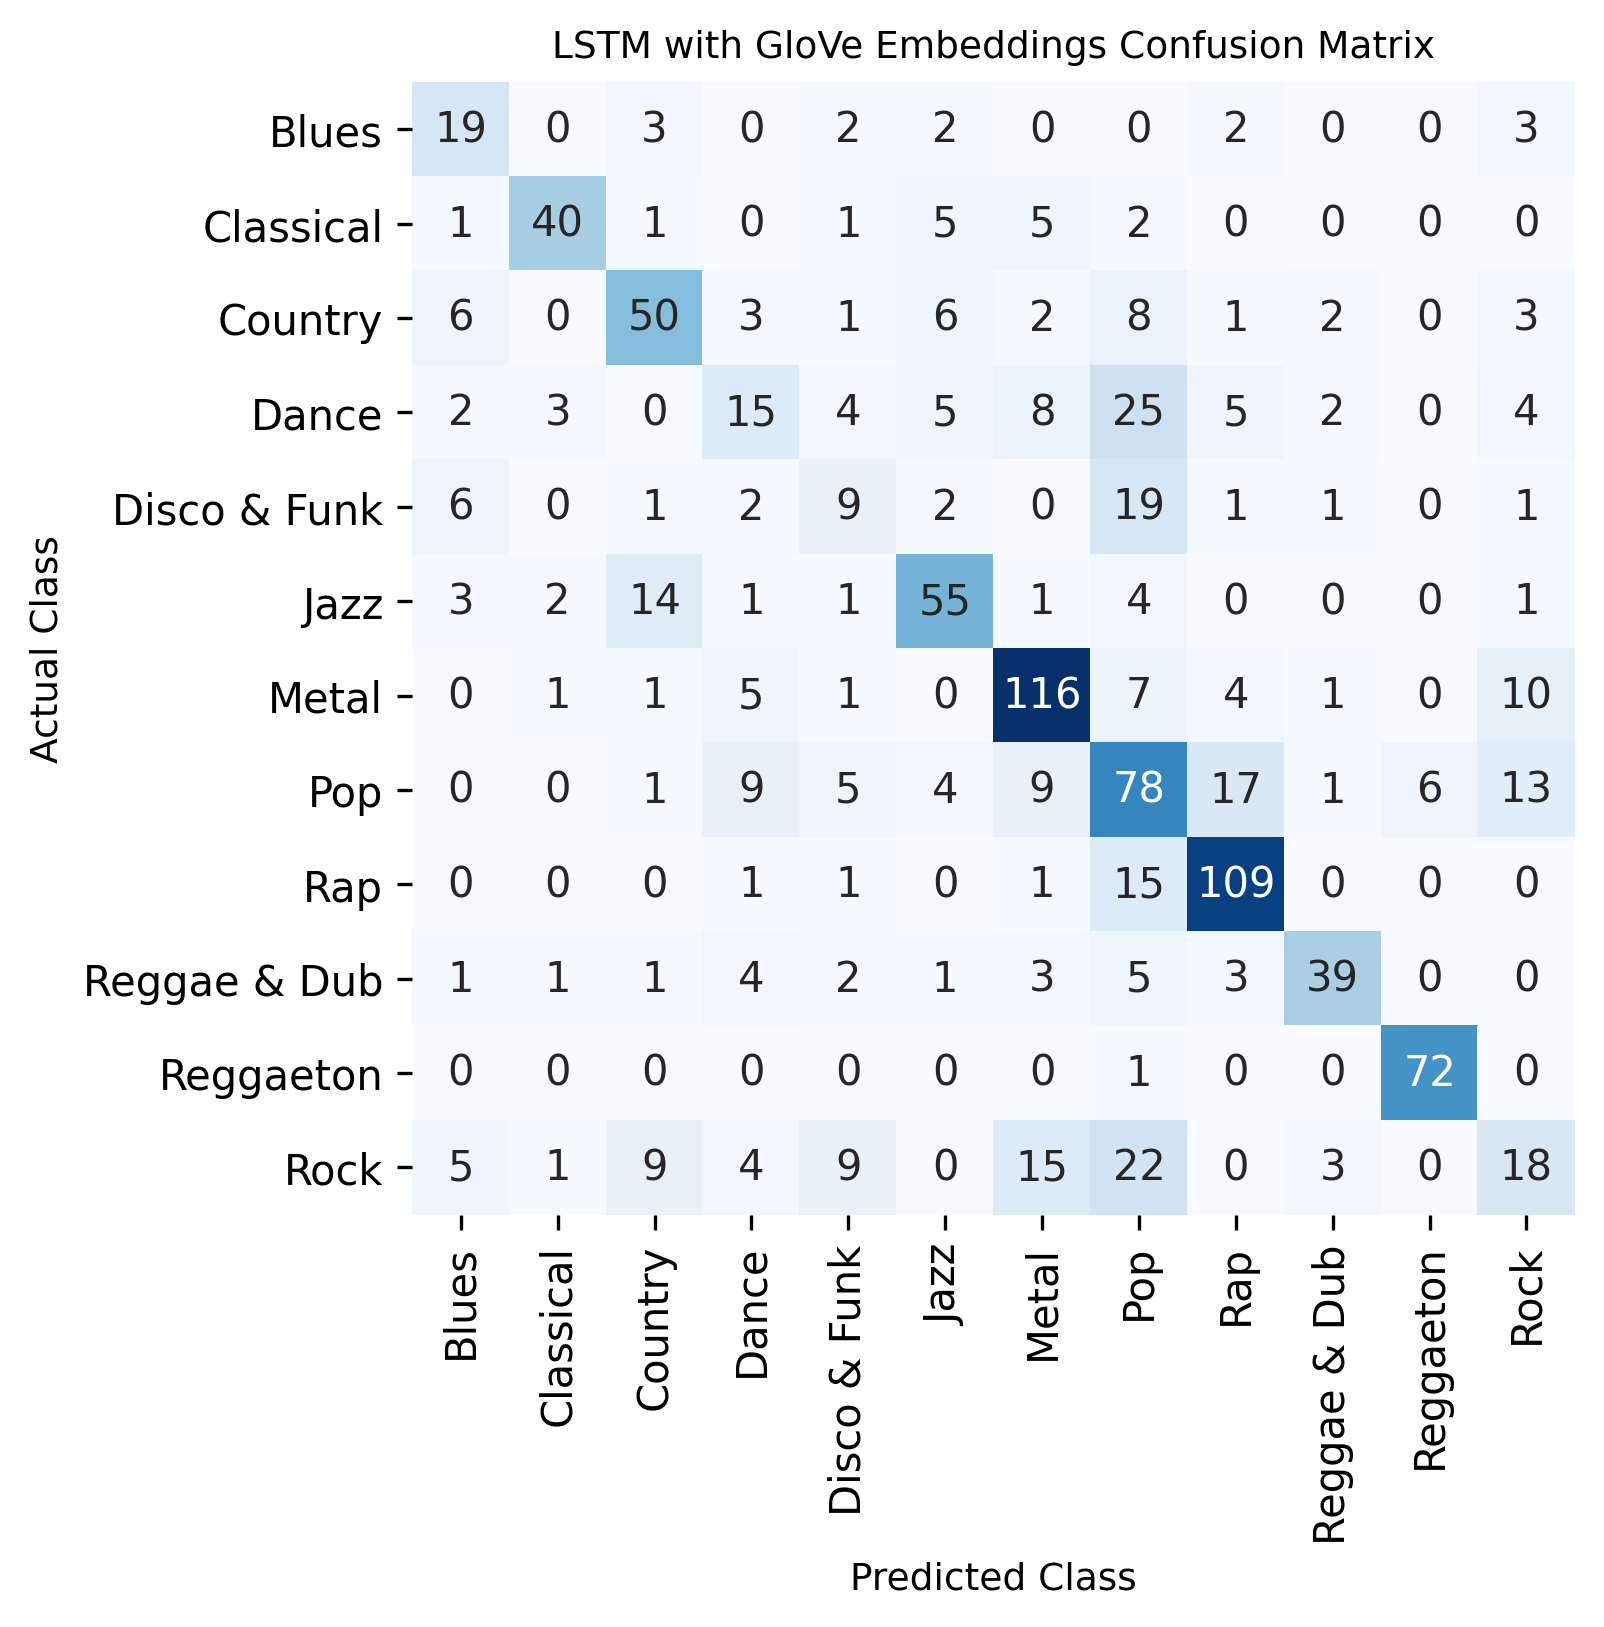

In [25]:
# Plot confusion matrix
alphabetical = []

for el in mood:
    if (el not in alphabetical):
        alphabetical.append(el)

alphabetical = sorted(alphabetical)

# Gets predicted labels from model
y_pred = lstm.predict(X_test_pad)

# Formats labels into appropriate class designations
y_pred_classes = np.zeros(len(y_pred)).astype(int)
y_test_classes = np.zeros(len(y_test)).astype(int)

for index, label in enumerate(y_pred):
    y_pred_classes[index] = np.argmax(y_pred[index])
    
for index, label in enumerate(y_test):
    y_test_classes[index] = np.argmax(y_test[index])

# Generates confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Formats and displays the confusion matrix
figure(num=None, figsize=(5, 5), dpi=300)
df_cm = pd.DataFrame(cm, index = alphabetical, columns = alphabetical)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues, fmt='g', cbar=False)
plt.title('LSTM with GloVe Embeddings Confusion Matrix', fontsize=9)
plt.xlabel("Predicted Class", fontsize=9)
plt.ylabel("Actual Class", fontsize=9)
plt.show()

In [26]:
# Cell for getting information about each class

new_test_classes = np.full(shape=y_test_classes.shape[0], fill_value="yoooooooooooooooo")
new_pred_classes = np.full(shape=y_pred_classes.shape[0], fill_value="yoooooooooooooooo")

for x in range(len(y_test_classes)):
    id1 = y_test_classes[x]
    id2 = y_pred_classes[x]

    word1 = alphabetical[id1]
    word2 = alphabetical[id2]

    new_test_classes[x] = word1
    new_pred_classes[x] = word2

print(classification_report(new_test_classes, new_pred_classes))

              precision    recall  f1-score   support

       Blues       0.44      0.61      0.51        31
   Classical       0.83      0.73      0.78        55
     Country       0.62      0.61      0.61        82
       Dance       0.34      0.21      0.26        73
Disco & Funk       0.25      0.21      0.23        42
        Jazz       0.69      0.67      0.68        82
       Metal       0.72      0.79      0.76       146
         Pop       0.42      0.55      0.47       143
         Rap       0.77      0.86      0.81       127
Reggae & Dub       0.80      0.65      0.72        60
   Reggaeton       0.92      0.99      0.95        73
        Rock       0.34      0.21      0.26        86

    accuracy                           0.62      1000
   macro avg       0.60      0.59      0.59      1000
weighted avg       0.61      0.62      0.61      1000



In [27]:
# Defines the Multiclass model, compiles and trains it

gru = Sequential()
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM, 
                            embeddings_initializer=Constant(embedding_matrix), 
                            input_length=max_num_tokens,
                            trainable=False)

gru.add(embedding_layer)
gru.add(SpatialDropout1D(0.2))
gru.add(Bidirectional(CuDNNGRU(100)))
gru.add(Dense(48, activation='relu'))
gru.add(Dense(24, activation='relu'))
gru.add(Dense(12, activation='softmax'))

checkpoint_filepath = 'GRU1'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose=1)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

op = keras.optimizers.Adam(learning_rate = lr_schedule)
gru.compile(optimizer = op, loss='categorical_crossentropy', metrics=['accuracy'])

print(gru.summary())

# Saves a History object for plotting
history = gru.fit(X_train_pad, y_train, batch_size=128, epochs=30, 
                    validation_data=(X_val_pad, y_val), verbose=2, callbacks=[model_checkpoint_callback])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1702, 300)         20604600  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1702, 300)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               241200    
_________________________________________________________________
dense_6 (Dense)              (None, 48)                9648      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_8 (Dense)              (None, 12)                300       
Total params: 20,856,924
Trainable params: 252,324
Non-trainable params: 20,604,600
____________________________________

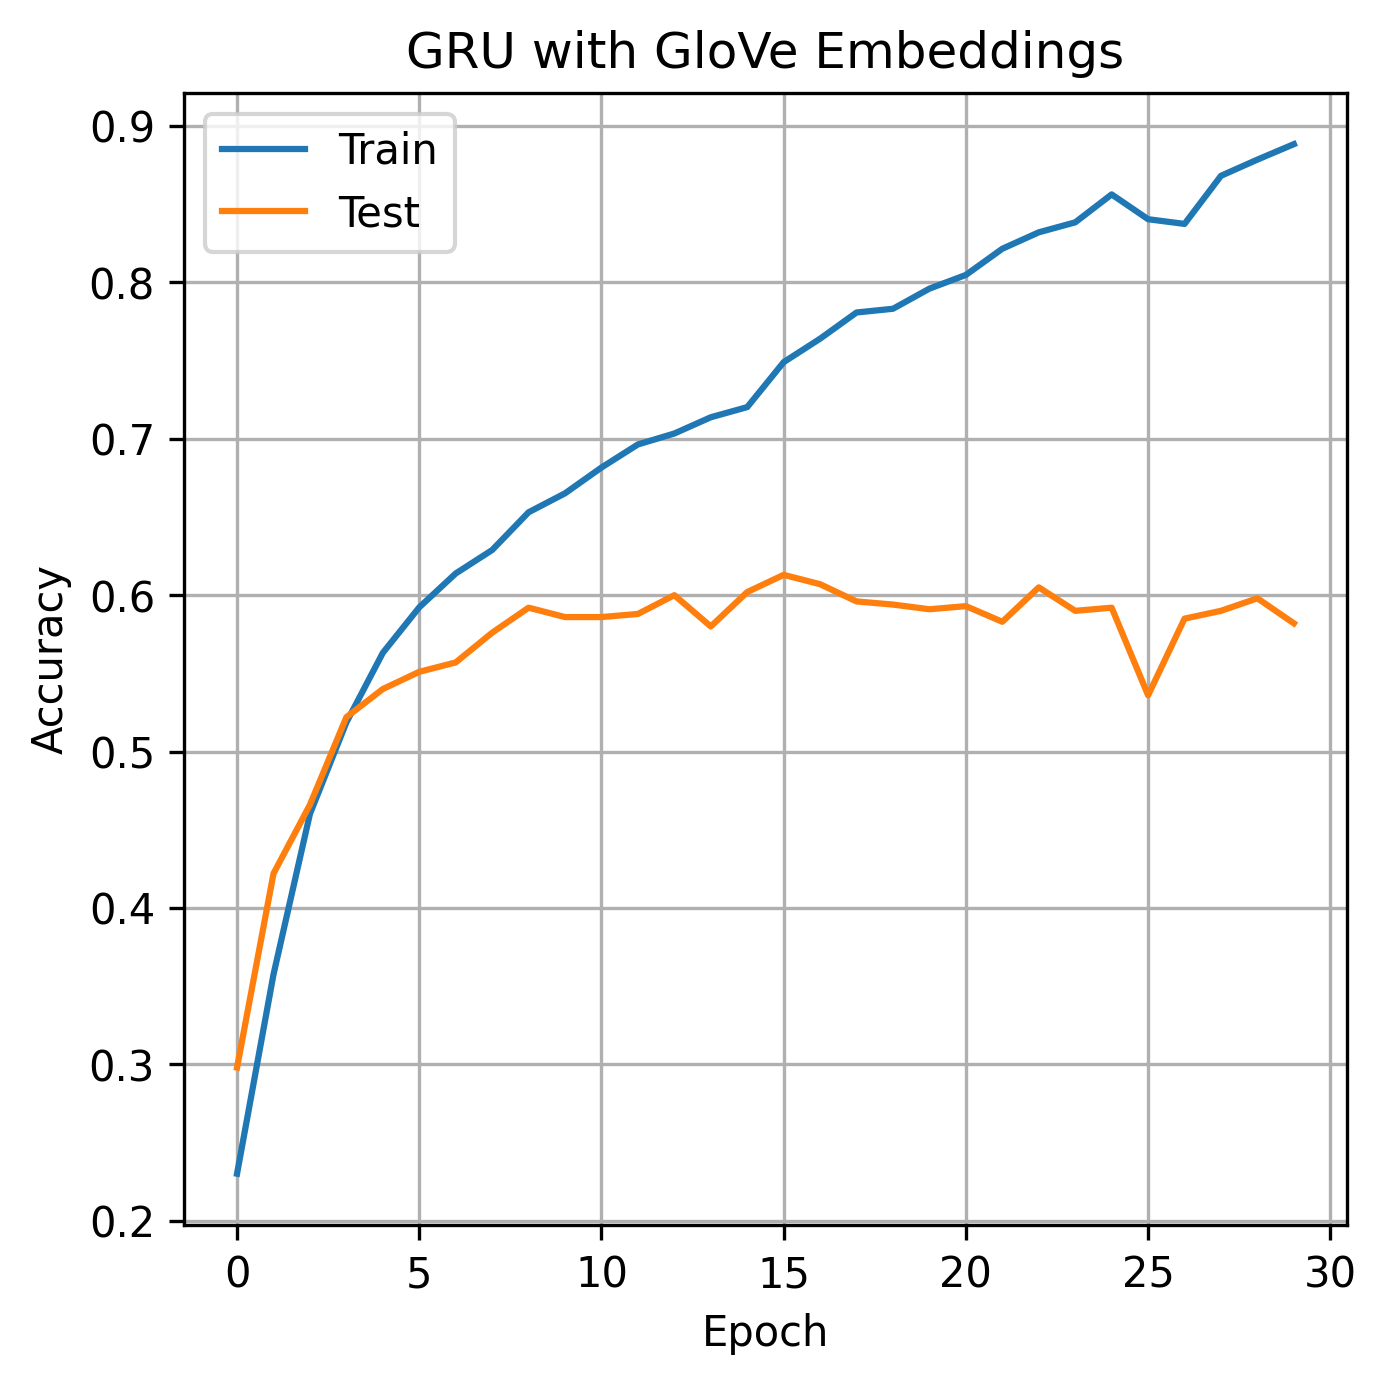

In [33]:
# Plot accuracy as a function of training epoch

figure(num=None, figsize=(5, 5), dpi=300)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True)
plt.title('GRU with GloVe Embeddings')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
gru.load_weights(checkpoint_filepath)

results = gru.evaluate(X_test_pad, y_test, batch_size=128)
print("test loss, test acc:", results)

print(gru.summary())

8/8 [==============================] - 1s 152ms/step - loss: 1.1681 - accuracy: 0.6430
test loss, test acc: [1.1680752038955688, 0.6430000066757202]
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1702, 300)         20604600  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1702, 300)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               241200    
_________________________________________________________________
dense_6 (Dense)              (None, 48)                9648      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_8 (Dense)              (None, 1

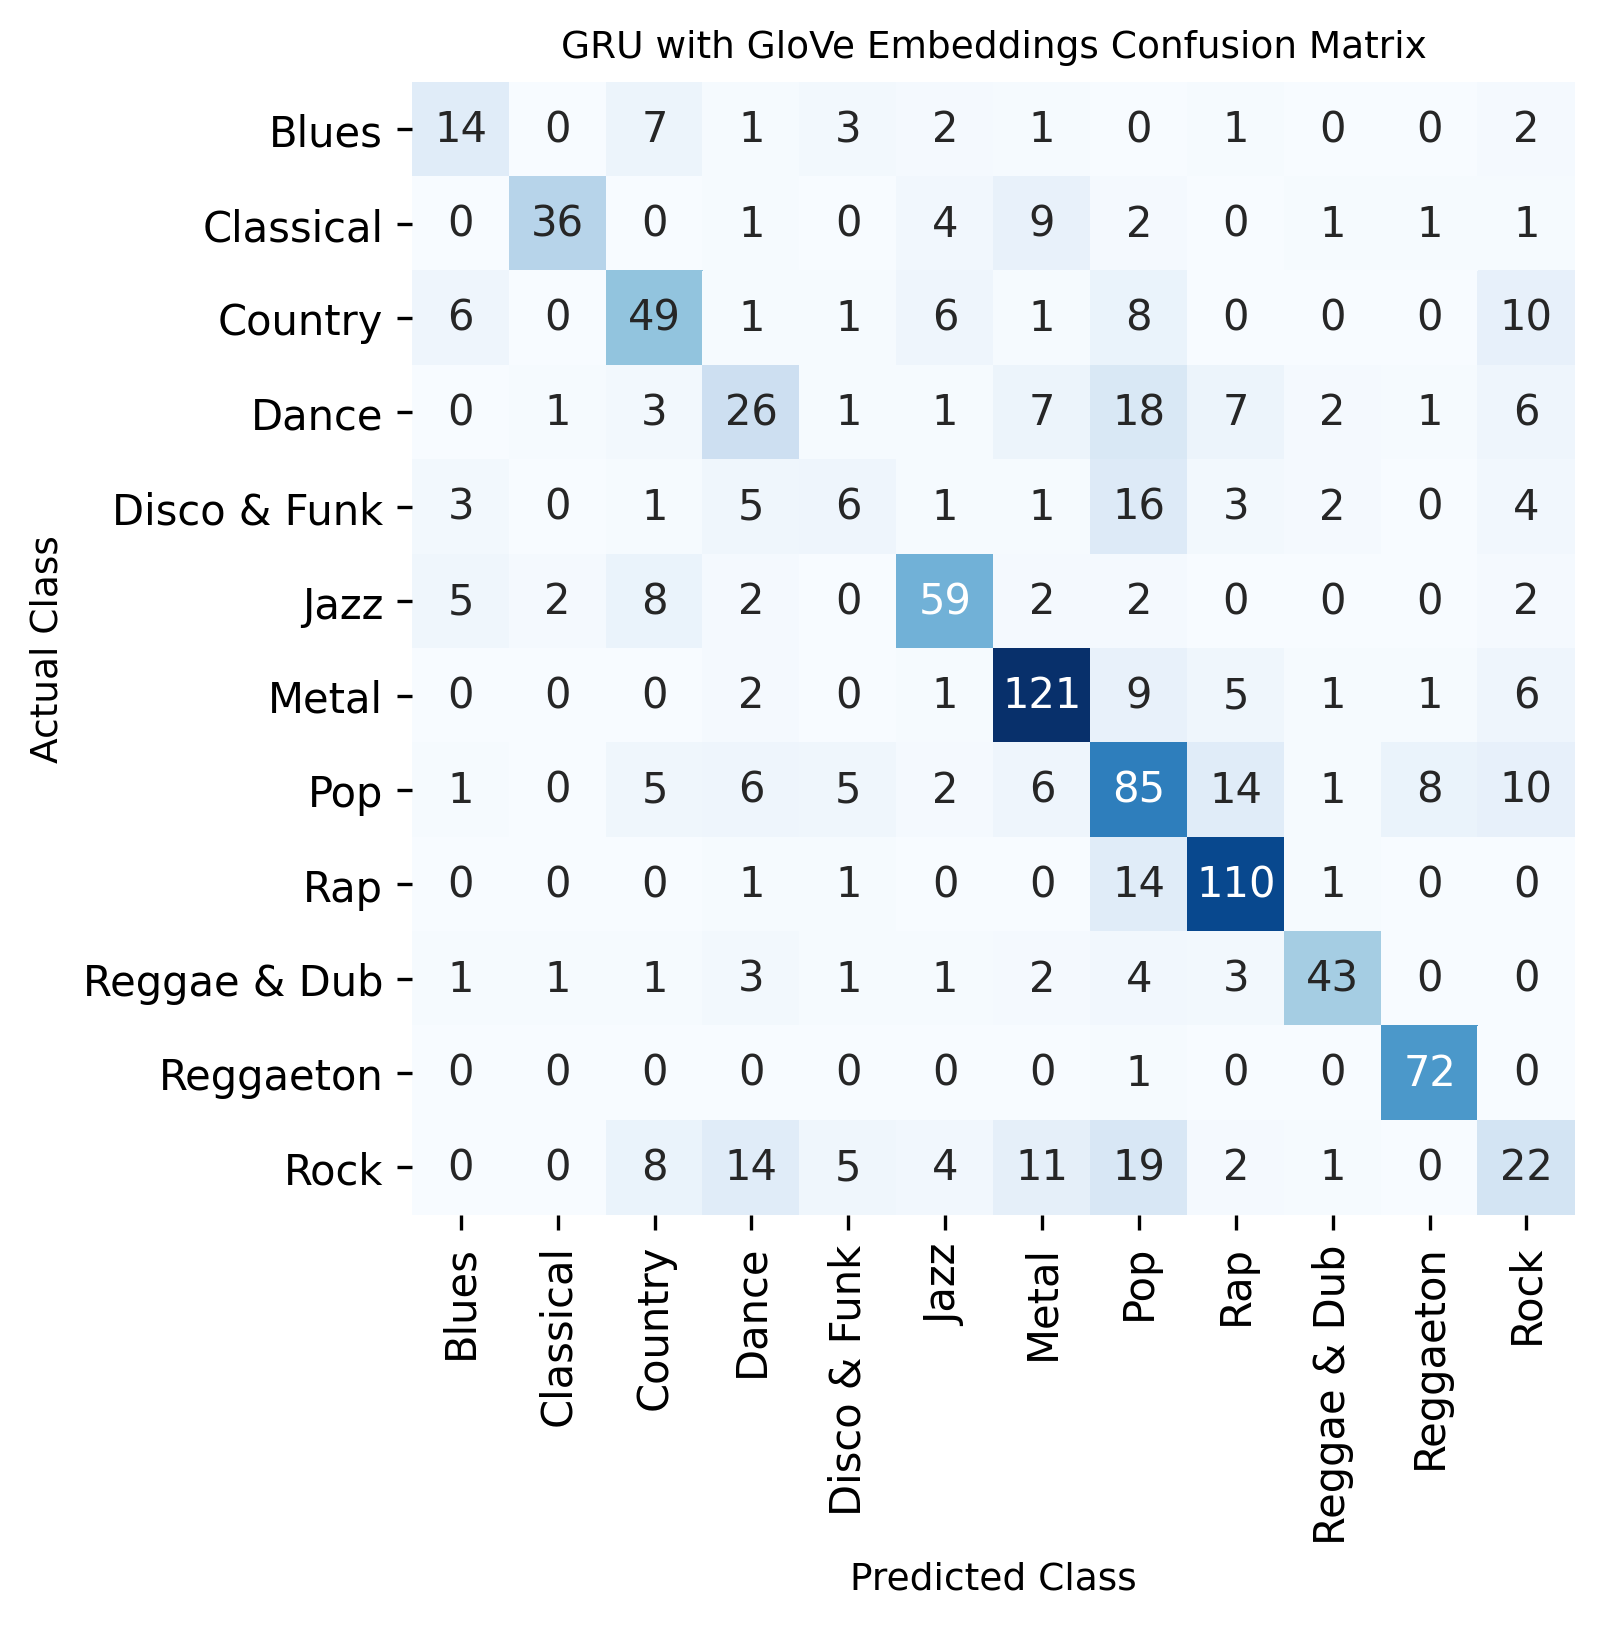

In [35]:
# Plot confusion matrix
alphabetical = []

for el in mood:
    if (el not in alphabetical):
        alphabetical.append(el)

alphabetical = sorted(alphabetical)

# Gets predicted labels from model
y_pred = gru.predict(X_test_pad)

# Formats labels into appropriate class designations
y_pred_classes = np.zeros(len(y_pred)).astype(int)
y_test_classes = np.zeros(len(y_test)).astype(int)

for index, label in enumerate(y_pred):
    y_pred_classes[index] = np.argmax(y_pred[index])
    
for index, label in enumerate(y_test):
    y_test_classes[index] = np.argmax(y_test[index])

# Generates confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Formats and displays the confusion matrix
figure(num=None, figsize=(5, 5), dpi=300)
df_cm = pd.DataFrame(cm, index = alphabetical, columns = alphabetical)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues, fmt='g', cbar=False)
plt.title('GRU with GloVe Embeddings Confusion Matrix', fontsize=9)
plt.xlabel("Predicted Class", fontsize=9)
plt.ylabel("Actual Class", fontsize=9)
plt.show()